# Learning Basic Reinforcement Learning

### Bellman's Equation

$$
V(s) = \max_a \left\{ R(s, a) + \gamma \sum_{s'} {P(s'|s,a) V(s')} \right\}
$$

- $s$ is the state
- $a$ is the action
- $V(s)$ is the value of state $s$
- $R(s, a)$ is the immediate reward for choosing action $a$ in state $s$
- $P(s'|s, a)$ is the probability of transitioning from state $s$ to state $s'$, by taking the action $a$
- $\gamma$ is the discount factor that determines the importance of future rewards

### Q-learning

Update the Q-value of a state-action pair based on the difference between the observed reward and the expected reward.

Q-value : The expected cumulative reward of taking action $a$ in state $s$ and following optimal policy thereafter.

$$
Q(s, a) = Q(s, a) + \alpha \left(R(s, a) + \gamma \max_{a'} \left\{Q(s',a')-Q(s,a)\right\}\right)

In [161]:
import numpy as np

class GridWorld:
    def __init__(self):
        self.width = 4
        self.height = 4
        self.state = np.array([0, 0], dtype=np.int32)
        self.treasure = np.array([3, 3], dtype=np.int32)
        self.pit = np.array([2, 2], dtype=np.int32)

    def step(self, action):
        reward = 0
        done = False
        
        if action == 0:
            self.state[0] = max(self.state[0] - 1, 0)
        elif action == 1:
            self.state[0] = min(self.state[0] + 1, self.height - 1)
        elif action == 2:
            self.state[1] = max(self.state[1] - 1, 0)
        elif action == 3:
            self.state[1] = min(self.state[1] + 1, self.width - 1)
        
        if np.all(self.state == self.treasure):
            reward = 1
            done = True
        elif np.all(self.state == self.pit):
            reward = -1
            done = True
        
        return self.state.copy(), reward, done
    
    def reset(self):
        self.state = np.array([0, 0], dtype=np.int32)
        return self.state


In [162]:
class QLearningAgent:
    # 멤버 객체 설정 및 저장
    def __init__(self, n_states=(4, 4), n_actions=4, gamma=0.9, epsilon=1.0, lr=0.1):
        self.n_states = n_states
        self.n_actions = n_actions
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.Q = np.zeros((n_states[0], n_states[1], n_actions))
        self.mem_cntr = 0

    # s를 받아서 Q-table에 따라 greedy action 선택
    def choose_action(self, state):
        self.epsilon = 10000 / (10000 + self.mem_cntr)
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space).item()
        else:
            action = np.argmax(self.Q[state[0], state[1], :])
        return action
    
    def learn(self, state, action, reward, next_state):
        q_next = np.max(self.Q[next_state[0], next_state[1], :])
        self.Q[state[0], state[1], action] += self.lr * (reward + self.gamma * q_next - self.Q[state[0], state[1], action])
    
        

In [163]:
import matplotlib.pyplot as plt

def plot_learning_curve(x, score_history, eps_history, avg_score_history, filename, lines=None):
    fig=plt.figure()
    ax1=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    x = [i+1 for i in range(len(score_history))]
    ax1.plot(x, eps_history, color="red")
    ax2.plot(x, avg_score_history, color="blue")
    
    ax1.set_xlabel("# episodes", color="black")
    ax1.set_ylabel("Epsilons / scores", color="red")
    ax1.tick_params(axis='x', colors="red")
    ax1.tick_params(axis='y', colors="red")

    plt.savefig(filename)

In [164]:
list_of_actions = ['up', 'down', 'left', 'right']

def visualize_Q_table(Q_table, n_states, n_actions, filename):
    M, N = n_states
      # Assuming this order for the actions
    if n_actions != len(list_of_actions):
        raise ValueError(f"Number of actions should be {len(list_of_actions)} for this visualization")

    # Create a heatmap for the maximum Q-values
    max_q_values = np.max(Q_table, axis=2)
    plt.imshow(max_q_values, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Max Q-value')

    # Add arrows for the policy (action with highest Q-value)
    for i in range(M):
        for j in range(N):
            best_action = np.argmax(Q_table[i, j])
            
            if list_of_actions[best_action] == "up":
                plt.arrow(j, i, 0, -0.3, head_width=0.2, head_length=0.2, fc='b', ec='b')
            elif list_of_actions[best_action] == "right":
                plt.arrow(j, i, 0.3, 0, head_width=0.2, head_length=0.2, fc='b', ec='b')
            elif list_of_actions[best_action] == "down":
                plt.arrow(j, i, 0, 0.3, head_width=0.2, head_length=0.2, fc='b', ec='b')
            elif list_of_actions[best_action] == "left":
                plt.arrow(j, i, -0.3, 0, head_width=0.2, head_length=0.2, fc='b', ec='b')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.xticks([]), plt.yticks([])  # Remove axis ticks for clarity
    plt.savefig(filename)

In [165]:
if __name__ == "__main__":
    env = GridWorld()
    agent = QLearningAgent(n_states=(4, 4), n_actions=4, gamma=0.5, epsilon=1.0, lr=0.01)
    # 변수 선언
    score_history, eps_history, avg_score_history = [], [], []
    n_games = 10000

    for i in range(n_games):
        # 변수 선언
        score = 0
        done = False
        state = env.reset()
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state)
            score += reward
            state = next_state
            agent.mem_cntr += 1
        avg_score = np.mean(score_history[-100:])
        avg_score_history.append(avg_score)
        score_history.append(score)
        eps_history.append(agent.epsilon)
        print(i, score, avg_score, agent.epsilon)


0 -1 nan 0.997307270370001
1 -1 -1.0 0.9920634920634921
2 -1 -1.0 0.9887284951552304
3 -1 -1.0 0.9864851533984413
4 -1 -1.0 0.9858044164037855
5 -1 -1.0 0.9814505839630975
6 -1 -1.0 0.9754194303550526
7 -1 -1.0 0.9722897423432183
8 -1 -1.0 0.969838037047813
9 -1 -1.0 0.9673986649898423
10 -1 -1.0 0.9641342074816814
11 -1 -1.0 0.9545628102329133
12 -1 -1.0 0.9530162965786715
13 -1 -1.0 0.9504799923961601
14 -1 -1.0 0.9458053532582994
15 -1 -1.0 0.9404683532399135
16 -1 -1.0 0.9360666479453337
17 1 -1.0 0.934317481080071
18 -1 -0.8888888888888888 0.9328358208955224
19 -1 -0.8947368421052632 0.92824654228163
20 -1 -0.9 0.9274717121127806
21 -1 -0.9047619047619048 0.9246417013407304
22 -1 -0.9090909090909091 0.9175995595522114
23 1 -0.9130434782608695 0.916590284142988
24 -1 -0.8333333333333334 0.9117432530999271
25 1 -0.84 0.910166560480568
26 -1 -0.7692307692307693 0.909835319807115
27 -1 -0.7777777777777778 0.9093389106119851
28 -1 -0.7857142857142857 0.9080177971488241
29 -1 -0.7931034

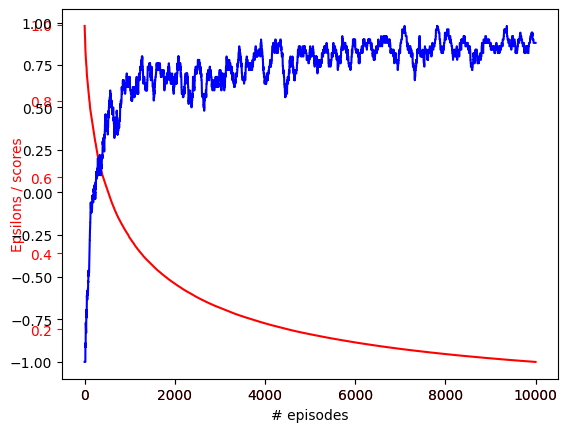

In [166]:
# Plot learning curve
x = [i+1 for i in range(n_games)]
plot_learning_curve(x, score_history, eps_history, avg_score_history, 'GridWorld-learning-curve.png')

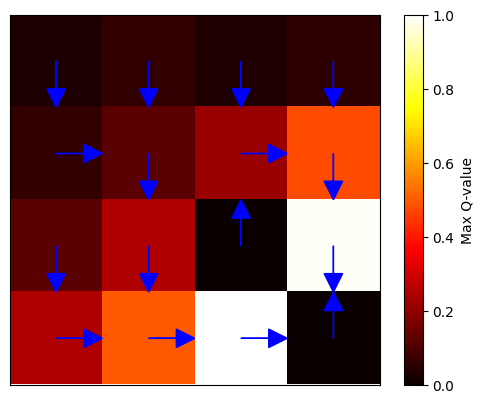

In [167]:
visualize_Q_table(agent.Q, agent.n_states, agent.n_actions, 'GridWorld-Q-values.png')